In [1]:
%load_ext autoreload
%autoreload 2

# Trap-limited conversion efficiency (TLC)
## the case of CZTSe

In [47]:
import numpy as np
import matplotlib.pyplot as plt

In [29]:
e = 1.60217662E-19 # elementary charge
kb = 8.6173303e-5  # Boltzmann constant
sun_power = 100.   # mW/cm2

In [22]:
thickness = 2000 # nm

## SC-FERMI

In [44]:
from run_scfermi import Scfermi

Tanneal = 854 # K
Tfrozen = 300 # K
dopants_anneal = []

scfermi = Scfermi.from_file(path="input-fermi_Se8,Zn1Se1,Sn1Se2.dat")


scfermi._run(T=Tanneal)
print("fermi_level (anneal): {:.3f} eV".format(scfermi.fermi_level))

scfermi._run(T=Tfrozen, mode='frozen')
print("fermi_level (frozen): {:.3f} eV".format(scfermi.fermi_level))

print('run completed at T = {:.2f} K'.format(scfermi.T))


fermi_level (anneal): 0.314 eV
fermi_level (frozen): 0.235 eV
run completed at T = 300.00 K


## SQ limit

In [45]:
import SQlimit

e_gap = scfermi.e_gap
temp = Tfrozen

sq = SQlimit.SQlim

param = sq(temp).get_paras(e_gap, False)
voc = param["Voc"]
jsc = param["Jsc"]
j0 = param["J0"]
vc = kb*temp

j_sq = lambda v: jsc + j0 * (1.-np.exp(v/vc))

print("===================")
print("SQlimit E_gap: {:.2f} eV at T={:.1f} K with W={:.2f} nm".format(e_gap, temp, thickness))
print("===================")
print("VOC: {:.3f} V, JSC: {:.3f} mA/cm2, J0: {:.3e} mA/cm2".format(voc, jsc, j0))
print("PCE: {:.3f} \%".format(param["PCE"]))
print("FF: {:.3f} \%".format(param["FF"]))
print("===================")




SQlimit E_gap: 1.01 eV at T=300.0 K with W=2000.00 nm
VOC: 0.774 V, JSC: 47.682 mA/cm2, J0: 4.741e-12 mA/cm2
PCE: 31.627 \%
FF: 85.696 \%


## Trap-limited conversion efficiency

In [46]:
from solarsim_linemode import solve_jv, read_traps

# read traps

trap_list = read_traps(file='trap.dat')

vout_list = np.linspace(0-0.1, e_gap, 100)
jout_list = []

for v in vout_list:
    j = solve_jv(scfermi, trap_list, v, thickness)
    jout_list.append(j)

power = jout_list*vout_list
max_i = np.argmax(power)

print("Trap-limited conversion efficiency")
print("-------------------------------"
    "\nJSC: {:.2f} (mA/cm2), ".format(jsc),
      "\nVOC: {:.2f} (V)".format(voc),
      "\n-------------------------------")
print("-------------------------------"
    "\nJ_max: {:.2f}, ".format(jout_list[max_i]),
      "\nV_max: {:.2f} (V),".format(vout_list[max_i]),
      "\nFF: {:.2f}%".format(100*power[max_i]/jsc/voc),
      "\neff: {:.2f}%".format(100*power[max_i]/sun_power),
      "\n-------------------------------")

Trap-limited conversion efficiency
-------------------------------
JSC: 47.68 (mA/cm2),  
VOC: 0.77 (V) 
-------------------------------
-------------------------------
J_max: 45.22,  
V_max: 0.45 (V), 
FF: 55.07% 
eff: 20.32% 
-------------------------------


Text(0, 0.5, 'J (meV/cm2)')

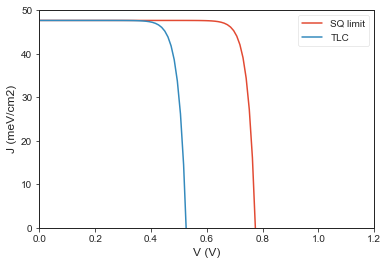

In [55]:
plt.plot(vout_list, j_sq(vout_list), label = "SQ limit")
plt.plot(vout_list, jout_list, label = "TLC")


plt.legend()


plt.ylim((0, 50))
plt.xlim((0, 1.2))
plt.xlabel("V (V)")
plt.ylabel("J (meV/cm2)")